In [ ]:
!pip install discopy
!pip install sympy
!pip install jax
!pip install noisyopt

In [34]:
import jax.numpy as np
from jax import jit
from discopy import Tensor
Tensor.np = np

from sympy import symbols 
from discopy import *
from discopy.quantum import *
import requests

In [128]:
#******************************************
# Generate your corpus
#******************************************
# sentences can be of the `word1 word2 word3 ...`
# if you are generating the diagrams using templates
# then you may want to consider adding POS tags (N, V, Adj) for each word
# labels should be of the form [0,1] or [1,0] for binary classification

# Words
adjectives  = ['cruel', 'strong', 'weak'] #'smart', 'happy', 'cowardly', 'brave', 'stupid', 'heroic', 'loving']
nouns =['professor', 'doctor', 'politician'] #'fireman', 'policeman', 'scientist', 'lawyer', 'physicist', 'nurse', 'mathematician']
verbs = ['wins', 'loses', 'lies','saves'] #'flees', 'kills', 'saves', 'cries', 'innovates', 'creates', 'believes']

# Verbal connotation
positive  = ['wins', 'saves','innovates', 'creates', 'believes']
negatives = ['loses', 'lies', 'flees', 'kills','cries']

# Sentences generator
sentences = []
labels = []
for adj in adjectives:
  for noun in nouns:
    for verb in verbs:
        sentences.append(adj + ' ' + noun + ' '+ verb)
        if verb in positive:
          labels.append(1)
        else:
          labels.append(0)

train_sentences = sentences[0:12]
dev_sentences   = sentences[12:24]
test_sentences  = sentences[24:]

train_labels = labels[0:12]
dev_labels   = labels[12:24]
test_labels  = labels[24:]

train_labels = np.array(train_labels)
dev_labels   = np.array(dev_labels)
test_labels  = np.array(test_labels)

In [129]:
#******************************************
# Generate your diagrams
#******************************************
# TODO generate the DisCoCat diagrams for your corpus. There are 2 options:
# 1. Follow a few fixed templates (N V N, N V Adj N, ...)
# 2. Use the online tool to generate diagrams. 
# If you are using the online tool, consider writing a script.

# Suggestion: print out some of your DisCoCat diagrams using
# `grammar.draw` to check that they make sense.

# TODO implement sentence2diagram

def sentence2diagram(sent):
  byte_string = requests.get("https://cqc.pythonanywhere.com/discocat/code?sentence=" + sent)
  processesed_string = ''
  for i in byte_string:
    processesed_string += i.decode('utf-8').replace('\n', '') 
  return processesed_string

train_diagrams = [eval(sentence2diagram(s)) for s in train_sentences]
dev_diagrams   = [eval(sentence2diagram(s)) for s in dev_sentences]
test_diagrams  = [eval(sentence2diagram(s)) for s in test_sentences]

In [130]:
len(dev_diagrams)

12

In [ ]:
###idea 1: use IQP ansantz to create bolier plate ansantz for 3 word sentences
#### idea 2: create custumized ansantz based on sentence diagram specifications
###idea 3: circuit functor

In [131]:
#******************************************
# Generate your circuits
#******************************************
# TODO: Implement your own functorial ansatz conversion!
# The `qnlp-tutorial` has some code on this.
# https://discopy.readthedocs.io/en/main/notebooks/qnlp-tutorial.html
# You may also find discopy's `IQPansatz` function useful.

# Suggestion: Draw some DisCoCat diagrams alongside their circuit diagrams
# and compare them

train_circuits = []
test_circuits  = []
val_circuits   = []

alpha = symbols("alpha")
beta  = symbols("beta")
sym_list = [alpha, beta]

for k in range(len(train_sentences)):
    train_circuits.append(IQPansatz(3,[[alpha, beta], [alpha, beta]]))
    test_circuits.append(IQPansatz(3,[[alpha, beta], [alpha, beta]]))
    val_circuits.append(IQPansatz(3,[[alpha, beta], [alpha, beta]]))

In [132]:
len(test_circuits)

12

In [26]:
# These imports will come in handy when you want to run
# backend simulations.

# from qiskit import IBMQ
# from pytket.extensions.qiskit import AerBackend, IBMQBackend, IBMQEmulatorBackend

In [133]:
#******************************************
# Counting parameters in your model
#******************************************
from sympy import default_sort_key
circuits = train_circuits + val_circuits + test_circuits

# Make sure you sort your symbols as they are returned as a set.

parameters = sorted({
    s for circ in circuits for s in circ.free_symbols
}, key=default_sort_key)

In [134]:
def normalise(predicts):
    # apply smoothing to predicts
    predicts = np.abs(predicts - 1e-9)
    predicts = predicts / predicts.sum()
    return predicts

def BCE_loss(predicts, labels):
    cross_entropies = np.sum(labels * np.log2(predicts))
    cost = -1/len(labels) * np.sum(cross_entropies)

    return cost

In [135]:
def make_pred_fn(circuits):
    def pred_fn(params):
        predictions = np.array([
            normalise(np.abs(c.lambdify(*parameters)(*params).eval().array))
            for c in circuits
        ])
        return predictions

    return pred_fn

In [137]:
train_pred_fn = jit(make_pred_fn(train_circuits))
dev_pred_fn   = jit(make_pred_fn(val_circuits))
test_pred_fn  = jit(make_pred_fn(test_circuits))

import numpy as onp
onp.random.seed(0)

x0 = np.array(onp.random.random(len(parameters)))
print("Performing Just-In-Time compilation, this may take a while...")
train_pred_fn(x0)
dev_pred_fn(x0)

Performing Just-In-Time compilation, this may take a while...


DeviceArray([[[[[[[0.01854655, 0.01149995],
                  [0.01615188, 0.01149995]],

                 [[0.01884021, 0.013414  ],
                  [0.02163345, 0.013414  ]]],


                [[[0.01149995, 0.01854655],
                  [0.01149995, 0.01615188]],

                 [[0.013414  , 0.01884021],
                  [0.013414  , 0.02163345]]]],



               [[[[0.01615188, 0.01149995],
                  [0.01854655, 0.01149995]],

                 [[0.02163345, 0.013414  ],
                  [0.01884021, 0.013414  ]]],


                [[[0.01149995, 0.01615188],
                  [0.01149995, 0.01854655]],

                 [[0.013414  , 0.02163345],
                  [0.013414  , 0.01884021]]]]],




              [[[[[0.01884021, 0.013414  ],
                  [0.02163345, 0.013414  ]],

                 [[0.01854655, 0.01149995],
                  [0.01615188, 0.01149995]]],


                [[[0.013414  , 0.01884021],
                  [0.013414  , 0.0216334

In [148]:
def make_cost_fn(pred_fn, labels):
    costs = []
    accs = []
    params_list = []
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)

        cost = BCE_loss(predictions, labels)
        acc = np.sum(np.round(predictions) == labels) / len(labels) / 2
        costs.append(cost)
        accs.append(acc)
        params_list.append(params)

        return cost

    return cost_fn, costs, accs, params_list

In [145]:
# Rerun this cell onwards, so you can reuse the JITed prediction functions

train_cost_fn, train_costs, train_accs, spsa_params = make_cost_fn(train_pred_fn, train_labels)
dev_cost_fn, dev_costs, dev_accs, callback_params = make_cost_fn(dev_pred_fn, dev_labels)
test_cost_fn, test_costs, test_accs, _ = make_cost_fn(test_pred_fn, test_labels)

In [146]:
train_costs

[]

In [141]:
from noisyopt import minimizeSPSA

minimizeSPSA(train_cost_fn, x0=x0, a=0.13, c=0.1, niter=1, callback=dev_cost_fn)

ValueError: ignored

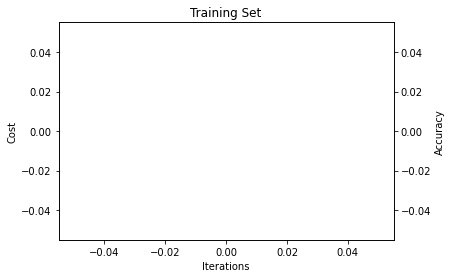

In [122]:
import matplotlib.pylab as plt
fig, ax1 = plt.subplots()
ax1.plot(train_costs[::2], color='#54436B')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Iterations')
ax1.set_title('Training Set')

ax2 = ax1.twinx()
ax2.plot(train_accs[::2], color='#50CB93')
ax2.set_ylabel('Accuracy')
plt.show()

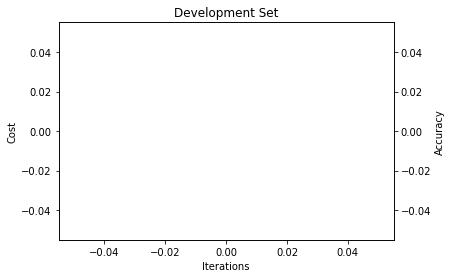

In [60]:
fig, ax1 = plt.subplots()
ax1.plot(dev_costs, color='#A03C78')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Iterations')
ax1.set_title('Development Set')

ax2 = ax1.twinx()
ax2.plot(dev_accs, color='#ED8E7C')
ax2.set_ylabel('Accuracy')
plt.show()

In [ ]:
# when you are happy with the development set results
# run your model on the testing set

# for p in callback_params:
#     test_cost_fn(p)

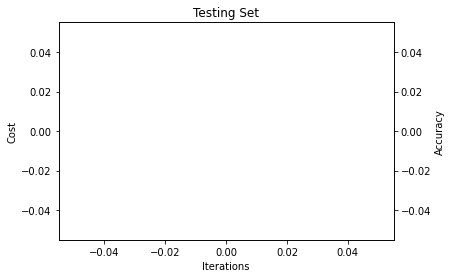

In [61]:
fig, ax1 = plt.subplots()
ax1.plot(test_costs, color='#7C83FD')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Iterations')
ax1.set_title('Testing Set')

ax2 = ax1.twinx()
ax2.plot(test_accs, color='#96BAFF')
ax2.set_ylabel('Accuracy')
plt.show()